# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO"s and use more than one TODO code cell to do all your tasks.

# Overview
This notebook outlines the process for an end-to-end image classification project, utilizing the resources and capabilities of AWS Sagemaker. The objective of this project is to create a deep learning model that is capable of identifying 133 different breeds of dogs. This project will use [Pytorch](https://pytorch.org/) as a deep learning framework and [Resnet50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html) as a pre-trained model.

# Project Pipeline
<div align='left'>
   <img src="./src/img/project-diagrams.png" alt="pipeline"style="width: 350px;"/>
</div>


In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
#!pip -qq install smdebug
!pip install -Uqq pip awscli sagemaker smdebug # botocore

In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

from sagemaker.session import Session
from sagemaker.inputs import TrainingInput
from sagemaker.pytorch import PyTorch
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

from sagemaker.debugger import(
    DebuggerHookConfig,
    ProfilerConfig,
    FrameworkProfile,
    Rule,
    ProfilerRule,
    rule_configs
)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-01-17 07:08:49.401 pytorch-1-12-gpu-py38-ml-t3-medium-5c243b1aae6a0c39c0e73a7744b4:25 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

This project use dog breeds image datasets from [here](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip). The datasets have been split to train, validation, and test set. The train set contains 6680 images divided into 133 classes corresponding to the dog breeds. The validation set contains 835 images and the test set contains 836 images. Both the validation set and test set have images for each class to check model performance.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
! wget -nc https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
! unzip -qq dogImages.zip

--2023-01-17 07:08:55--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.121.104
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.121.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  29.8MB/s    in 49s     

2023-01-17 07:09:46 (22.1 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]



In [66]:
! aws s3 sync /root/dog-breed-classification/dogImages s3://sagemaker-us-east-1-493104814313/dog-breed/data/ --quiet

In [13]:
import os

os.listdir("/root/dog-breed-classification/dogImages/")

['test', 'valid', 'train']

the dataset already splitted to test, valid, and train

In [204]:
import pandas as pd
import torchvision
from PIL import ImageFile

%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_dataset = torchvision.datasets.ImageFolder("~/dog-breed-classification/dogImages/train")
valid_dataset = torchvision.datasets.ImageFolder("~/dog-breed-classification/dogImages/valid")
test_dataset = torchvision.datasets.ImageFolder("~/dog-breed-classification/dogImages/test")

def get_class_distribution(dataset_obj):
    idx2class = {v: k for k, v in dataset_obj.class_to_idx.items()}
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    for _, label_id in dataset_obj:
        label = idx2class[label_id]
        count_dict[label] += 1
    return count_dict

In [17]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 6680
    Root location: /root/dog-breed-classification/dogImages/train

In [19]:
valid_dataset

Dataset ImageFolder
    Number of datapoints: 835
    Root location: /root/dog-breed-classification/dogImages/valid

In [20]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 836
    Root location: /root/dog-breed-classification/dogImages/test

In [50]:
print(f"total_class: {len(train_dataset.classes)}")
print(train_dataset.class_to_idx)

total_class: 133
{'001.Affenpinscher': 0, '002.Afghan_hound': 1, '003.Airedale_terrier': 2, '004.Akita': 3, '005.Alaskan_malamute': 4, '006.American_eskimo_dog': 5, '007.American_foxhound': 6, '008.American_staffordshire_terrier': 7, '009.American_water_spaniel': 8, '010.Anatolian_shepherd_dog': 9, '011.Australian_cattle_dog': 10, '012.Australian_shepherd': 11, '013.Australian_terrier': 12, '014.Basenji': 13, '015.Basset_hound': 14, '016.Beagle': 15, '017.Bearded_collie': 16, '018.Beauceron': 17, '019.Bedlington_terrier': 18, '020.Belgian_malinois': 19, '021.Belgian_sheepdog': 20, '022.Belgian_tervuren': 21, '023.Bernese_mountain_dog': 22, '024.Bichon_frise': 23, '025.Black_and_tan_coonhound': 24, '026.Black_russian_terrier': 25, '027.Bloodhound': 26, '028.Bluetick_coonhound': 27, '029.Border_collie': 28, '030.Border_terrier': 29, '031.Borzoi': 30, '032.Boston_terrier': 31, '033.Bouvier_des_flandres': 32, '034.Boxer': 33, '035.Boykin_spaniel': 34, '036.Briard': 35, '037.Brittany': 36, 

There're **133 classes** (dog breeds) with index 0 to 132

In [54]:
# Get the total sample of each class.
class_dist = get_class_distribution(train_dataset)
class_dist

{'001.Affenpinscher': 64,
 '002.Afghan_hound': 58,
 '003.Airedale_terrier': 52,
 '004.Akita': 63,
 '005.Alaskan_malamute': 77,
 '006.American_eskimo_dog': 64,
 '007.American_foxhound': 50,
 '008.American_staffordshire_terrier': 66,
 '009.American_water_spaniel': 34,
 '010.Anatolian_shepherd_dog': 50,
 '011.Australian_cattle_dog': 66,
 '012.Australian_shepherd': 66,
 '013.Australian_terrier': 46,
 '014.Basenji': 69,
 '015.Basset_hound': 73,
 '016.Beagle': 59,
 '017.Bearded_collie': 62,
 '018.Beauceron': 50,
 '019.Bedlington_terrier': 48,
 '020.Belgian_malinois': 62,
 '021.Belgian_sheepdog': 64,
 '022.Belgian_tervuren': 47,
 '023.Bernese_mountain_dog': 65,
 '024.Bichon_frise': 62,
 '025.Black_and_tan_coonhound': 37,
 '026.Black_russian_terrier': 41,
 '027.Bloodhound': 64,
 '028.Bluetick_coonhound': 35,
 '029.Border_collie': 74,
 '030.Border_terrier': 52,
 '031.Borzoi': 56,
 '032.Boston_terrier': 65,
 '033.Bouvier_des_flandres': 45,
 '034.Boxer': 64,
 '035.Boykin_spaniel': 53,
 '036.Briar

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

- **Batch size**
Neural networks are trained using gradient descent where the estimate of the error used to update the weights is calculated based on a subset of the training dataset. The number of examples from the training dataset used in the estimate of the error gradient is called the batch size and is an important hyperparameter that influences the dynamics of the learning algorithm.
- **Epoch**
The number of epochs is a hyperparameter of gradient descent that controls the number of complete passes through the training dataset. Small epoch used for educational purposes and cost saving.
- **Learning rate**
The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. Choosing the learning rate is challenging as a value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process.
- **Step Size and Gamma**
Adam can substantially benefit from a scheduled learning rate multiplier. In this project step-based (drop-based) learning rate scheduler is used. So the learning rate will drop by gamma for every step size (epoch).

References:[1, ](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/#:~:text=Batch%20size%20controls%20the%20accuracy,stability%20of%20the%20learning%20process)[2, ](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/)[3, ](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/)[4](https://discuss.pytorch.org/t/with-adam-optimizer-is-it-necessary-to-use-a-learning-scheduler/66477/2)

In [13]:
role = sagemaker.get_execution_role()

#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "epochs": IntegerParameter(3, 21),
    "learning_rate": ContinuousParameter(1e-5, 0.1),
    "step_size": IntegerParameter(1, 3),
    "gamma": CategoricalParameter([0.25, 0.5]),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

In [14]:
#TODO: Create estimators for your HPs
# TODO: Your estimator here
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name="dog-breed-clf",
    role=role,
    instance_type="ml.g4dn.xlarge",
    instance_count=1,
    framework_version="1.12",
    py_version="py38",
)

In [24]:
# TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator=estimator,
    base_tuning_job_name="dog-breed-clf-hpo",
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=20,
    max_parallel_jobs=2,
    objective_metric_name="validation accucary",
    objective_type="Maximize",
    metric_definitions=[{"Name": "validation accucary", "Regex": "valid_acc: ([0-9\\.]+)"}],
    early_stopping_type='Auto',
)

In [25]:
# TODO: Fit your HP Tuner
# TODO: Remember to include your data channels
tuner.fit({
    "train": "s3://sagemaker-us-east-1-022926224205/dog-breed-project/data/train/",
    "valid": "s3://sagemaker-us-east-1-022926224205/dog-breed-project/data/valid/",
    "test": "s3://sagemaker-us-east-1-022926224205/dog-breed-project/data/test/"
})

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: dog-breed-clf-hpo-230113-0640


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [26]:
# TODO: Get the best estimators and the best HPs
#TODO
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-01-13 08:27:22 Starting - Found matching resource for reuse
2023-01-13 08:27:22 Downloading - Downloading input data
2023-01-13 08:27:22 Training - Training image download completed. Training in progress.
2023-01-13 08:27:22 Uploading - Uploading generated training model
2023-01-13 08:27:22 Completed - Resource reused by training job: dog-breed-clf-hpo-230113-0640-020-0fbb3380


{'_tuning_objective_metric': '"validation accucary"',
 'batch_size': '"32"',
 'epochs': '6',
 'gamma': '"0.5"',
 'learning_rate': '0.0165806029105236',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-clf-2023-01-13-06-40-03-227"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-022926224205/dog-breed-clf-2023-01-13-06-40-03-227/source/sourcedir.tar.gz"',
 'step_size': '1'}

In [27]:
# Get results from HPO
import pandas as pd

tuning_job_name = tuner.latest_tuning_job.name
tuner_results = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
# Get the results as a dataframe
full_df = tuner_results.dataframe()
##Display results sorted by objective metric values
if len(full_df) > 0:
    df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df) > 0:
        df = df.sort_values("FinalObjectiveValue", ascending=False)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest": min(df["FinalObjectiveValue"]), "highest": max(df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", None)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

df

Number of training jobs with valid objective: 20
{'lowest': 0.007199999876320362, 'highest': 0.8754000067710876}


,batch_size,epochs,gamma,learning_rate,step_size,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
2,"""32""",6.0,"""0.5""",0.016581,1.0,dog-breed-clf-hpo-230113-0640-018-9346f6ce,Completed,0.8754,2023-01-13 08:14:08+00:00,2023-01-13 08:22:36+00:00,508.0
9,"""64""",21.0,"""0.5""",0.002352,3.0,dog-breed-clf-hpo-230113-0640-011-e6297d35,Completed,0.8743,2023-01-13 07:30:34+00:00,2023-01-13 07:56:12+00:00,1538.0
4,"""256""",21.0,"""0.25""",0.015431,3.0,dog-breed-clf-hpo-230113-0640-016-5401b3c0,Completed,0.8659,2023-01-13 08:00:47+00:00,2023-01-13 08:27:09+00:00,1582.0
18,"""64""",11.0,"""0.5""",0.001056,3.0,dog-breed-clf-hpo-230113-0640-002-d04c545f,Completed,0.8659,2023-01-13 06:41:30+00:00,2023-01-13 06:58:16+00:00,1006.0
6,"""512""",9.0,"""0.25""",0.014302,3.0,dog-breed-clf-hpo-230113-0640-014-099201c9,Completed,0.8659,2023-01-13 07:44:24+00:00,2023-01-13 08:00:15+00:00,951.0
3,"""128""",8.0,"""0.25""",0.006920,3.0,dog-breed-clf-hpo-230113-0640-017-2d261ecc,Completed,0.8635,2023-01-13 08:01:48+00:00,2023-01-13 08:12:52+00:00,664.0
16,"""256""",7.0,"""0.5""",0.013632,2.0,dog-breed-clf-hpo-230113-0640-004-45dcf8e8,Completed,0.8599,2023-01-13 06:54:47+00:00,2023-01-13 07:04:46+00:00,599.0
0,"""128""",7.0,"""0.5""",0.024945,1.0,dog-breed-clf-hpo-230113-0640-020-0fbb3380,Completed,0.8563,2023-01-13 08:27:23+00:00,2023-01-13 08:37:22+00:00,599.0
17,"""128""",4.0,"""0.5""",0.002613,3.0,dog-breed-clf-hpo-230113-0640-003-b08b256a,Completed,0.8539,2023-01-13 06:47:29+00:00,2023-01-13 06:54:38+00:00,429.0
11,"""128""",16.0,"""0.5""",0.003374,1.0,dog-breed-clf-hpo-230113-0640-009-e281b060,Completed,0.8491,2023-01-13 07:09:51+00:00,2023-01-13 07:29:47+00:00,1196.0


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [ ]:
# I did the hpo several days ago
hyperparams = {
    '_tuning_objective_metric': '"validation accucary"',
     'batch_size': '"32"',
     'epochs': '6',
     'gamma': '"0.5"',
     'learning_rate': '0.0165806029105236',
     'sagemaker_container_log_level': '20',
     'sagemaker_estimator_class_name': '"PyTorch"',
     'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
     'sagemaker_job_name': '"dog-breed-clf-2023-01-13-06-40-03-227"',
     'sagemaker_program': '"hpo.py"',
     'sagemaker_region': '"us-east-1"',
     'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-022926224205/dog-breed-clf-2023-01-13-06-40-03-227/source/sourcedir.tar.gz"',
     'step_size': '1'
}

In [ ]:
# TODO: Set up debugging and profiling rules and hooks
keys = ["epochs", "learning_rate", "step_size", "gamma", "batch_size"]
#dp_hyperparameters = {x:best_estimator.hyperparameters()[x] for x in keys}
dp_hyperparameters = {x:hyperparams[x] for x in keys}


rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.CPUBottleneck()),
    ProfilerRule.sagemaker(rule_configs.OverallSystemUsage()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10", "eval.save_interval": "1"}
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile()
)

In [249]:
# TODO: Create and fit an estimator
# TODO: Your estimator here
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="dog-breed-clf-dp",
    role=role,
    instance_type="ml.g4dn.xlarge",
    instance_count=1,
    framework_version="1.12",
    py_version="py38",
    hyperparameters=dp_hyperparameters,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
    rules=rules,
)

estimator.fit({
    "train": "s3://sagemaker-us-east-1-493104814313/dog-breed/data/train/",
    "valid": "s3://sagemaker-us-east-1-493104814313/dog-breed/data/valid/",
    "test": "s3://sagemaker-us-east-1-493104814313/dog-breed/data/test/"
})

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.i

2023-01-17 12:24:12 Starting - Starting the training job...
2023-01-17 12:24:29 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
CPUBottleneck: InProgress
OverallSystemUsage: InProgress
ProfilerReport: InProgress
......
2023-01-17 12:25:30 Downloading - Downloading input data......
2023-01-17 12:26:30 Training - Downloading the training image...............
2023-01-17 12:29:11 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-01-17 12:29:29,533 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-01-17 12:29:29,553 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-01-17 12:29:29,564 sagemaker_pytor

In [250]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'VanishingGradient',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:493104814313:processing-job/dog-breed-clf-dp-2023-01-1-vanishinggradient-447ec3ae',
  'RuleEvaluationStatus': 'Error',
  'StatusDetails': 'InternalServerError: We encountered an internal error. Please try again.',
  'LastModifiedTime': datetime.datetime(2023, 1, 17, 12, 34, 32, 831000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overfit',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:493104814313:processing-job/dog-breed-clf-dp-2023-01-1-overfit-afe4e7c1',
  'RuleEvaluationStatus': 'Error',
  'StatusDetails': 'InternalServerError: We encountered an internal error. Please try again.',
  'LastModifiedTime': datetime.datetime(2023, 1, 17, 12, 34, 32, 831000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'Overtraining',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:493104814313:processing-job/dog-breed-clf-dp-2023-01-1-overtraining-792b8a84',
  'RuleEvaluationStatus

In [251]:
# Print the latest training job's rule summary
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

import time
from IPython import display

%matplotlib inline

for description["SecondaryStatus"] in {"Stopped", "Completed"}:
    description = client.describe_training_job(TrainingJobName=job_name)
    primary_status = description["TrainingJobStatus"]
    secondary_status = description["SecondaryStatus"]
    print("====================================================================")
    print("TrainingJobStatus: ", primary_status, " | SecondaryStatus: ", secondary_status)
    print("====================================================================")
    for r in range(len(estimator.latest_training_job.rule_job_summary())):
        rule_summary = estimator.latest_training_job.rule_job_summary()
        print(
            rule_summary[r]["RuleConfigurationName"], ": ", rule_summary[r]["RuleEvaluationStatus"]
        )
        if rule_summary[r]["RuleEvaluationStatus"] == "IssuesFound":
            print(rule_summary[r]["StatusDetails"])
        print("====================================================================")
    print("Current time: ", time.asctime())
    display.clear_output(wait=True)
    time.sleep(1)

TrainingJobStatus:  Completed  | SecondaryStatus:  Completed
VanishingGradient :  Error
Overfit :  Error
Overtraining :  Error
PoorWeightInitialization :  Error
LossNotDecreasing :  Error
LowGPUUtilization :  IssuesFound
RuleEvaluationConditionMet: Evaluation of the rule LowGPUUtilization at step 9 resulted in the condition being met

CPUBottleneck :  NoIssuesFound
OverallSystemUsage :  NoIssuesFound
ProfilerReport :  IssuesFound
RuleEvaluationConditionMet: Evaluation of the rule ProfilerReport at step 12 resulted in the condition being met

Current time:  Tue Jan 17 12:38:36 2023


In [252]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-01-17 12:38:37.485 pytorch-1-12-gpu-py38-ml-t3-medium-5c243b1aae6a0c39c0e73a7744b4:25 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-493104814313/dog-breed-clf-dp-2023-01-17-12-24-11-930/debug-output


In [253]:
trial.tensor_names()

[2023-01-17 12:38:37.827 pytorch-1-12-gpu-py38-ml-t3-medium-5c243b1aae6a0c39c0e73a7744b4:25 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-01-17 12:38:38.843 pytorch-1-12-gpu-py38-ml-t3-medium-5c243b1aae6a0c39c0e73a7744b4:25 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.bias',
 'gradient/ResNet_fc.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.relu_input_2',
 'layer3.4.relu_input_0',
 'layer3.4.relu_input_1',
 '

In [256]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


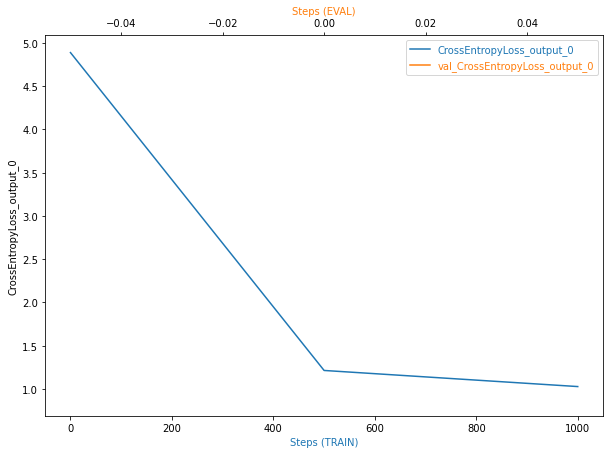

In [261]:
# TODO: Plot a debugging output.
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [262]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

session = boto3.session.Session()
region = session.region_name
training_job_name = estimator.latest_training_job.name
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-493104814313/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 7, "NumSteps": 1, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 5, "NumSteps": 1, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 13, "NumSteps": 1, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 9, "NumSteps": 3, "ProfilerName": "cprofile", "cProfileTimer": "default", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 15, "NumSteps": 1, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-493104814313/dog-breed-clf-dp-2023-01-17-12-24-11-930/profiler-output


Profiler data from system is available


In [263]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2023-01-17 12:39:43.917 pytorch-1-12-gpu-py38-ml-t3-medium-5c243b1aae6a0c39c0e73a7744b4:25 INFO metrics_reader_base.py:134] Getting 13 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1'}


In [264]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 cp {rule_output_path} ./ --recursive

You will find the profiler report in s3://sagemaker-us-east-1-493104814313/dog-breed-clf-dp-2023-01-17-12-24-11-930/rule-output
download: s3://sagemaker-us-east-1-493104814313/dog-breed-clf-dp-2023-01-17-12-24-11-930/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-493104814313/dog-breed-clf-dp-2023-01-17-12-24-11-930/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-493104814313/dog-breed-clf-dp-2023-01-17-12-24-11-930/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-493104814313/dog-breed-clf-dp-2023-01-17-12-24-11-930/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/B

In [265]:
# TODO: Display the profiler output
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [277]:
import os
import json

import boto3
import sagemaker
import torch
import torch.nn.functional as F
from sagemaker.pytorch import PyTorchModel
from sagemaker.serializers import JSONSerializer, IdentitySerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker import get_execution_role, Session

In [278]:
model_data = estimator.model_data
role = get_execution_role()

model = PyTorchModel(
    entry_point="inference.py",
    source_dir="./src/code",
    role=role,
    model_data=model_data,
    framework_version="1.12",
    py_version="py38",
)

In [279]:
# TODO: Deploy your model to an endpoint
# TODO: Add your deployment configuration like instance type and number of instances
predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    serializer=IdentitySerializer("image/jpg"),
    deserializer=JSONDeserializer(),
    endpoint_name="dog-breed-classifier"
)

INFO:sagemaker:Creating model with name: pytorch-inference-2023-01-17-12-45-57-680
INFO:sagemaker:Creating endpoint-config with name dog-breed-classifier
INFO:sagemaker:Creating endpoint with name dog-breed-classifier


--------!

prediction: 001.Affenpinscher, probability:  0.9997


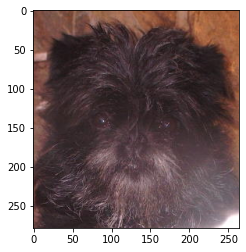

In [281]:
# TODO: Run an prediction on the endpoint
# TODO: Your code to load and preprocess image to send to endpoint for prediction

test_classes = {v: k for k, v in test_dataset.class_to_idx.items()}

img_path = "./dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg"
with open(img_path,"rb") as img:
    b_img = img.read()
    
res = predictor.predict(b_img)
idx = torch.argmax(torch.tensor(res), 1)
pred_class = test_classes.get(idx.item())
probs = F.softmax(torch.tensor(res), 1).squeeze()
prob = probs[idx.item()]

preview = Image.open(img_path)
plt.imshow(preview)

print(f"prediction: {pred_class}, probability: {prob: .4f}")

In [282]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: dog-breed-classifier
INFO:sagemaker:Deleting endpoint with name: dog-breed-classifier
